# Required Libraries

In [1]:
library(GEOquery)
library(limma)
library(Biobase)
library(pheatmap)
library(reshape2)
library(plyr)
library(ggplot2)
library(stringr)

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; vie

# Loading Data

At first, we store the name of dataset, so we'll be able to run the same procedure for other datasets in future analysis.

In [2]:
seriesName <- "GSE48558"
platformName <- "GPL6244"

Set working directory and then downloading the dataset:

In [3]:
#setwd('...')
gset <- getGEO(seriesName, GSEMatrix =TRUE, AnnotGPL=TRUE , destdir = "Data")
if (length(gset) > 1){
idx <- grep(platformName, attr(gset, "names"))
} else {
  idx <- 1
}
gset <- gset[[idx]]

Found 1 file(s)

GSE48558_series_matrix.txt.gz

Using locally cached version: Data/GSE48558_series_matrix.txt.gz

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.

Using locally cached version of GPL6244 found here:
Data/GPL6244.annot.gz 



Selecting the samples with "AML Patient" Source Name or "Normal" Phenotype:

In [4]:
gset<- gset[,which(gset$source_name_ch1 == "AML Patient" | gset$`phenotype:ch1` == "Normal")]

Creating labels (group names):

In [5]:
func <- function(x) {
  if (gset$source_name_ch1[x] == "AML Patient") {
    return("Test")
  } else {
    spll <- strsplit2(gset$source_name_ch1[x] , "\\+")[1, 1]
    return(paste0("Normal_" , spll))
  }
}



gr <- sapply(1:length(gset$`phenotype:ch1`) , func)


# Analysis

Generating gene expression and checking its maximum and minimum values:

In [6]:
expr <- exprs(gset)
print(paste0("Max Expr: " , max(expr)))
print(paste0("Min Expr: " , min(expr)))

[1] "Max Expr: 13.76153622"
[1] "Min Expr: 1.611473179"


## Boxplot

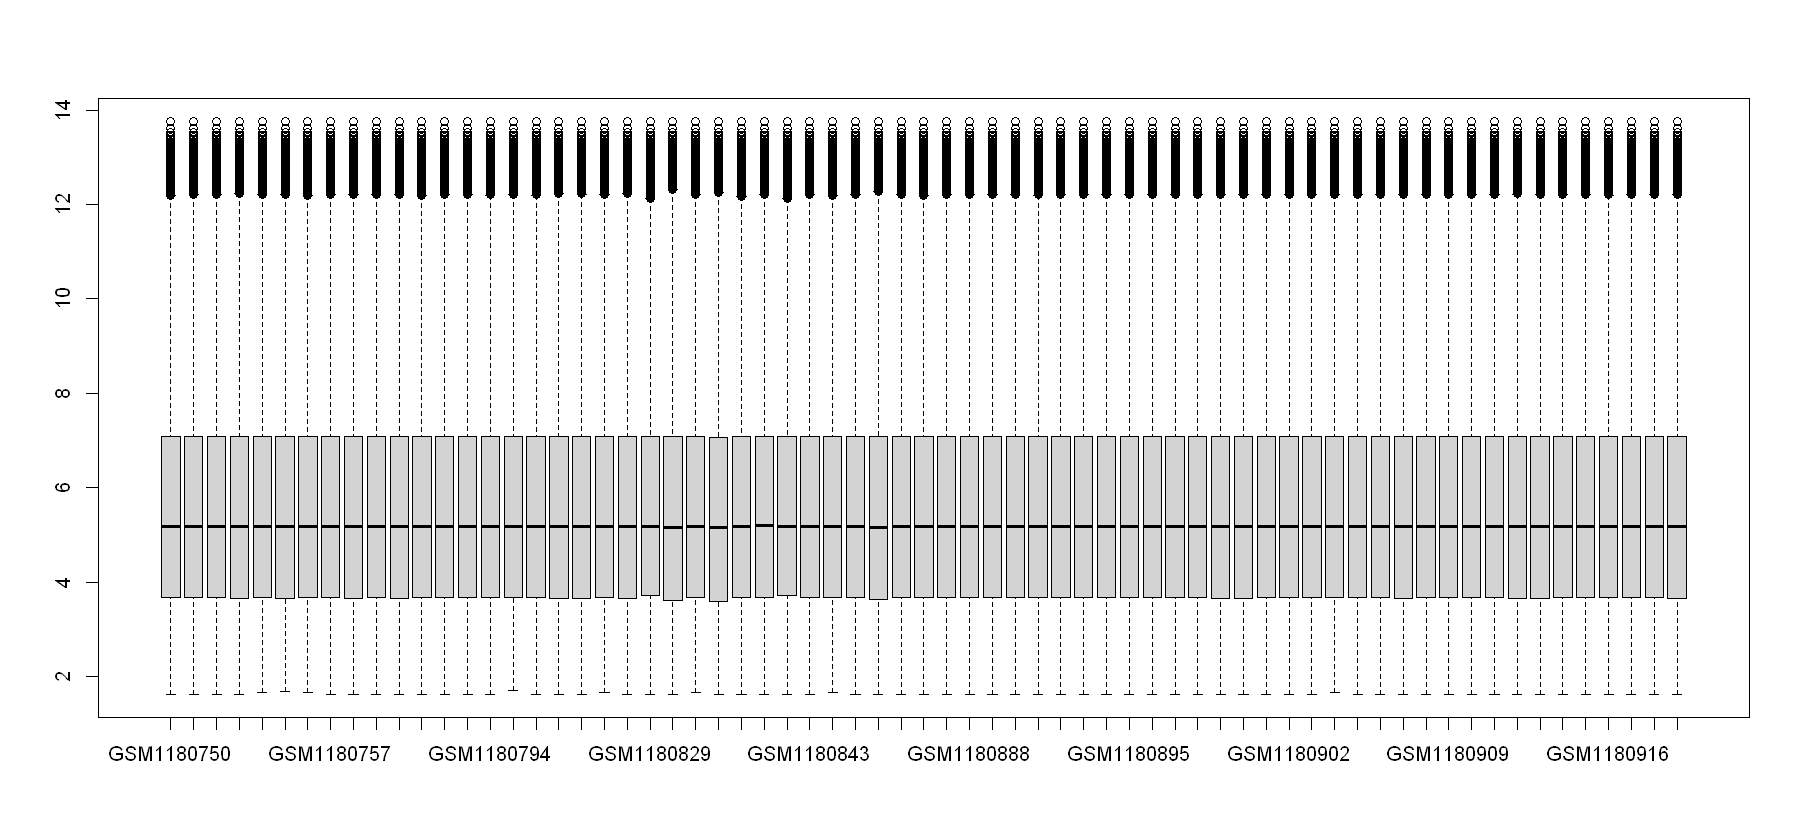

In [2]:
options(repr.plot.width = 15)
boxplot(expr)

The result shows that medians are aligned, so we do not need normaliztion. If you need normalization, uncomment and run the following block:

In [12]:
#expr<- normalizeQuantiles(expr)
#exprs(gset) <- expr

## Principal Component Analysis

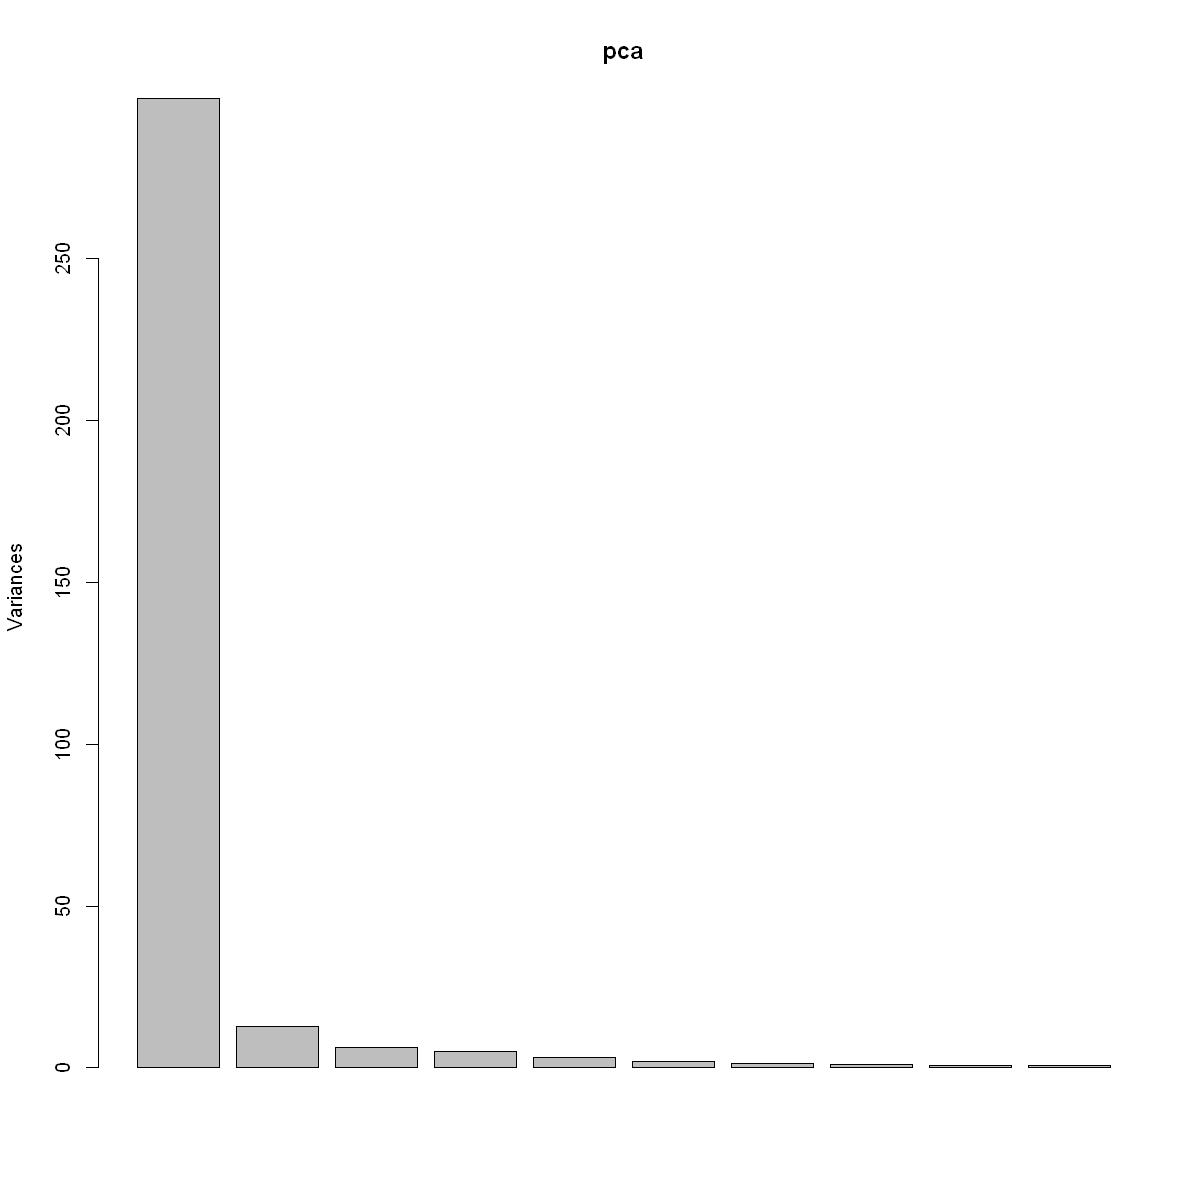

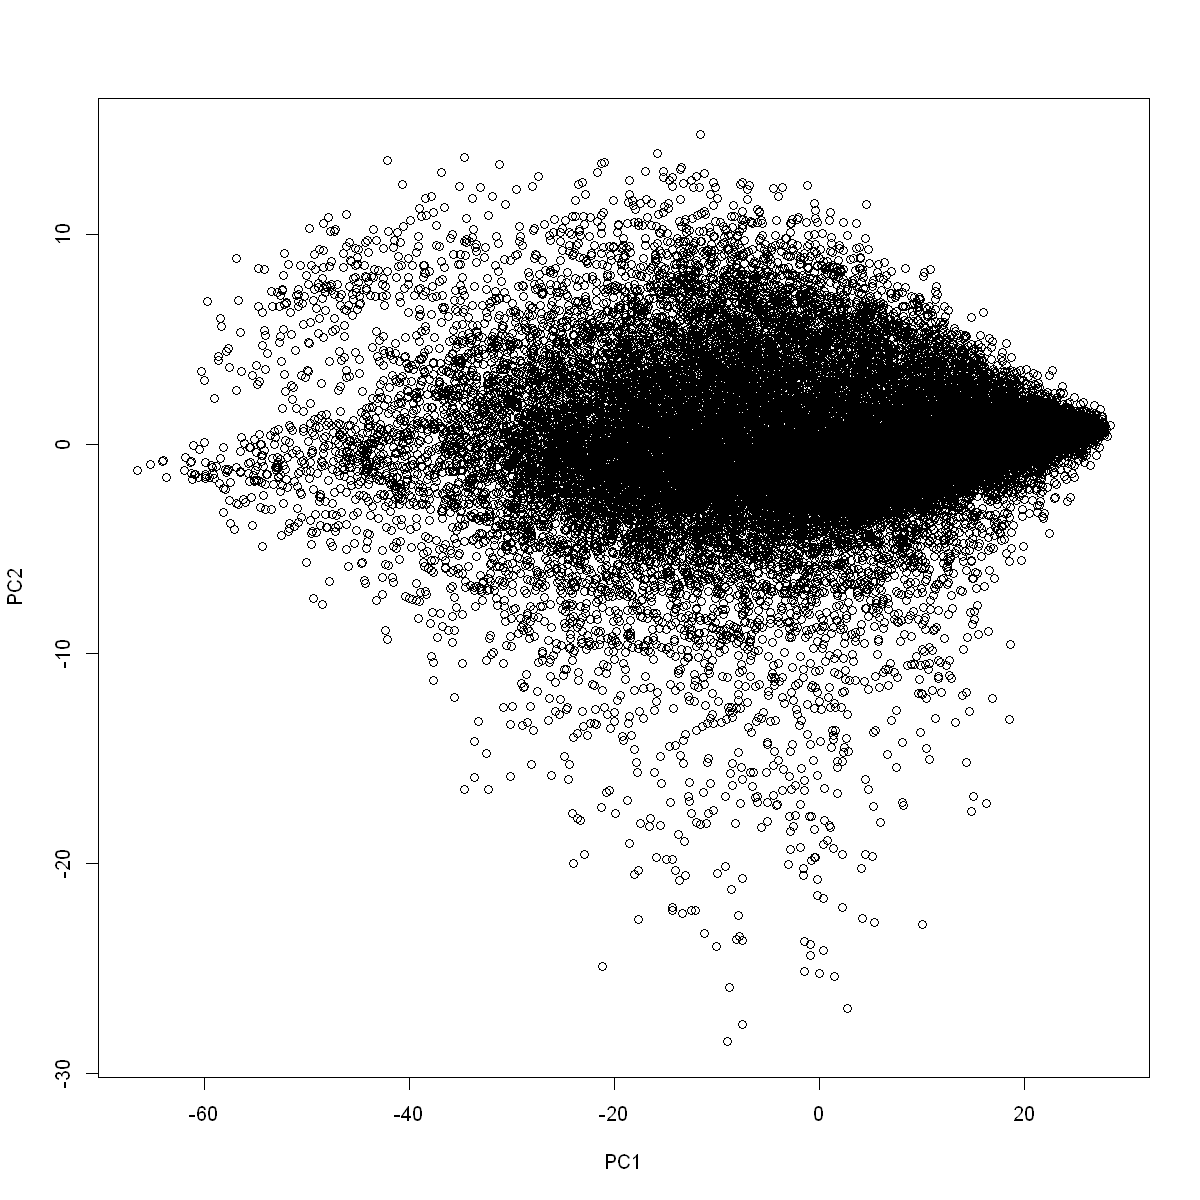

In [40]:
pca <- prcomp(expr)
options(repr.plot.width = 10 ,repr.plot.height = 10 )
plot(pca)
plot(pca$x[,1:2])

As we see, PCA components only detected high expression of housekeeping genes that are present in all cells and low expression of rarely expressed genes. This will not help us in differentiating genes that are related to AML. So we Scale the expression to make means equal to zero. By doing this, the PCA will not detect high expression of genes that are used everywhere. instead, it will detect significant results that are usefull for our work.

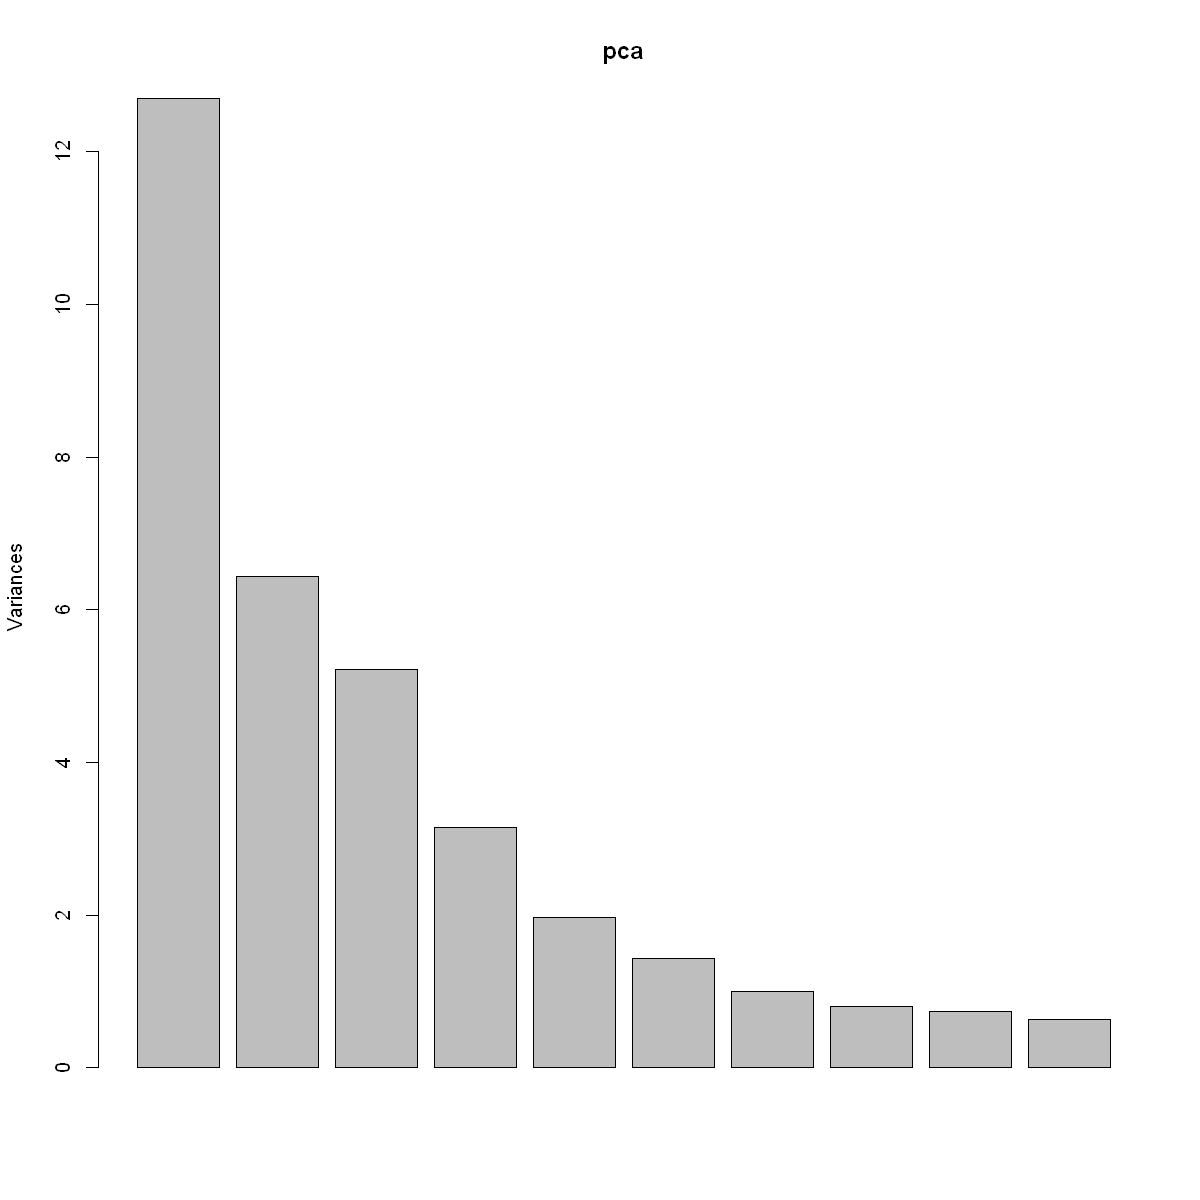

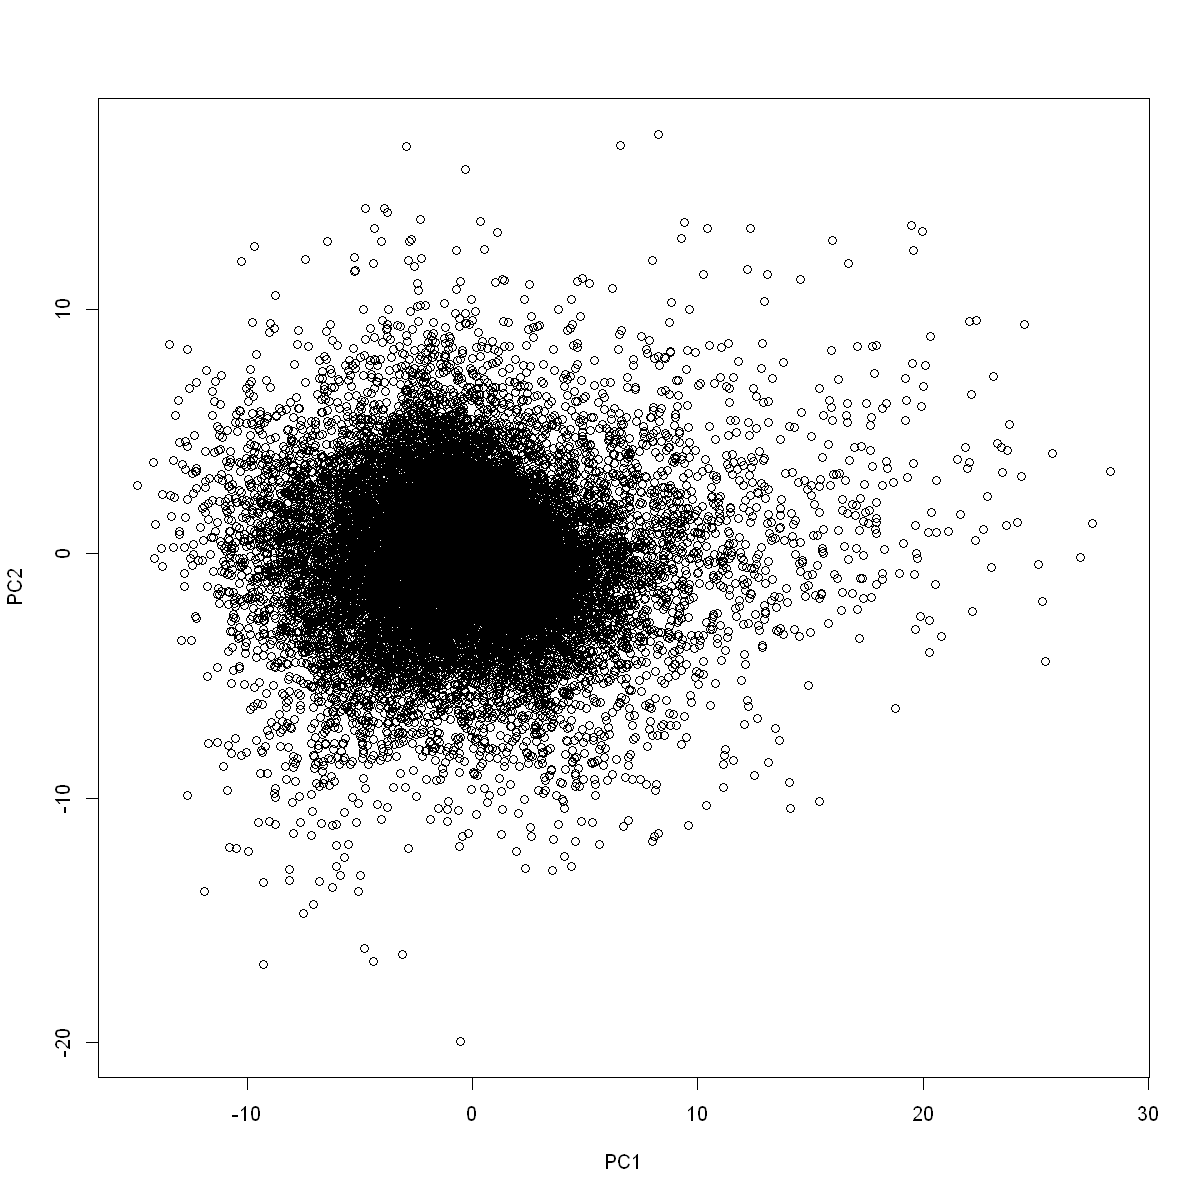

In [41]:
expr.scaled <- t(scale(t(expr) , scale = FALSE))
pca <- prcomp(expr.scaled)
options(repr.plot.width = 10 ,repr.plot.height = 10 )
plot(pca)
plot(pca$x[,1:2])

Now we plot a point plot using ggplot2:

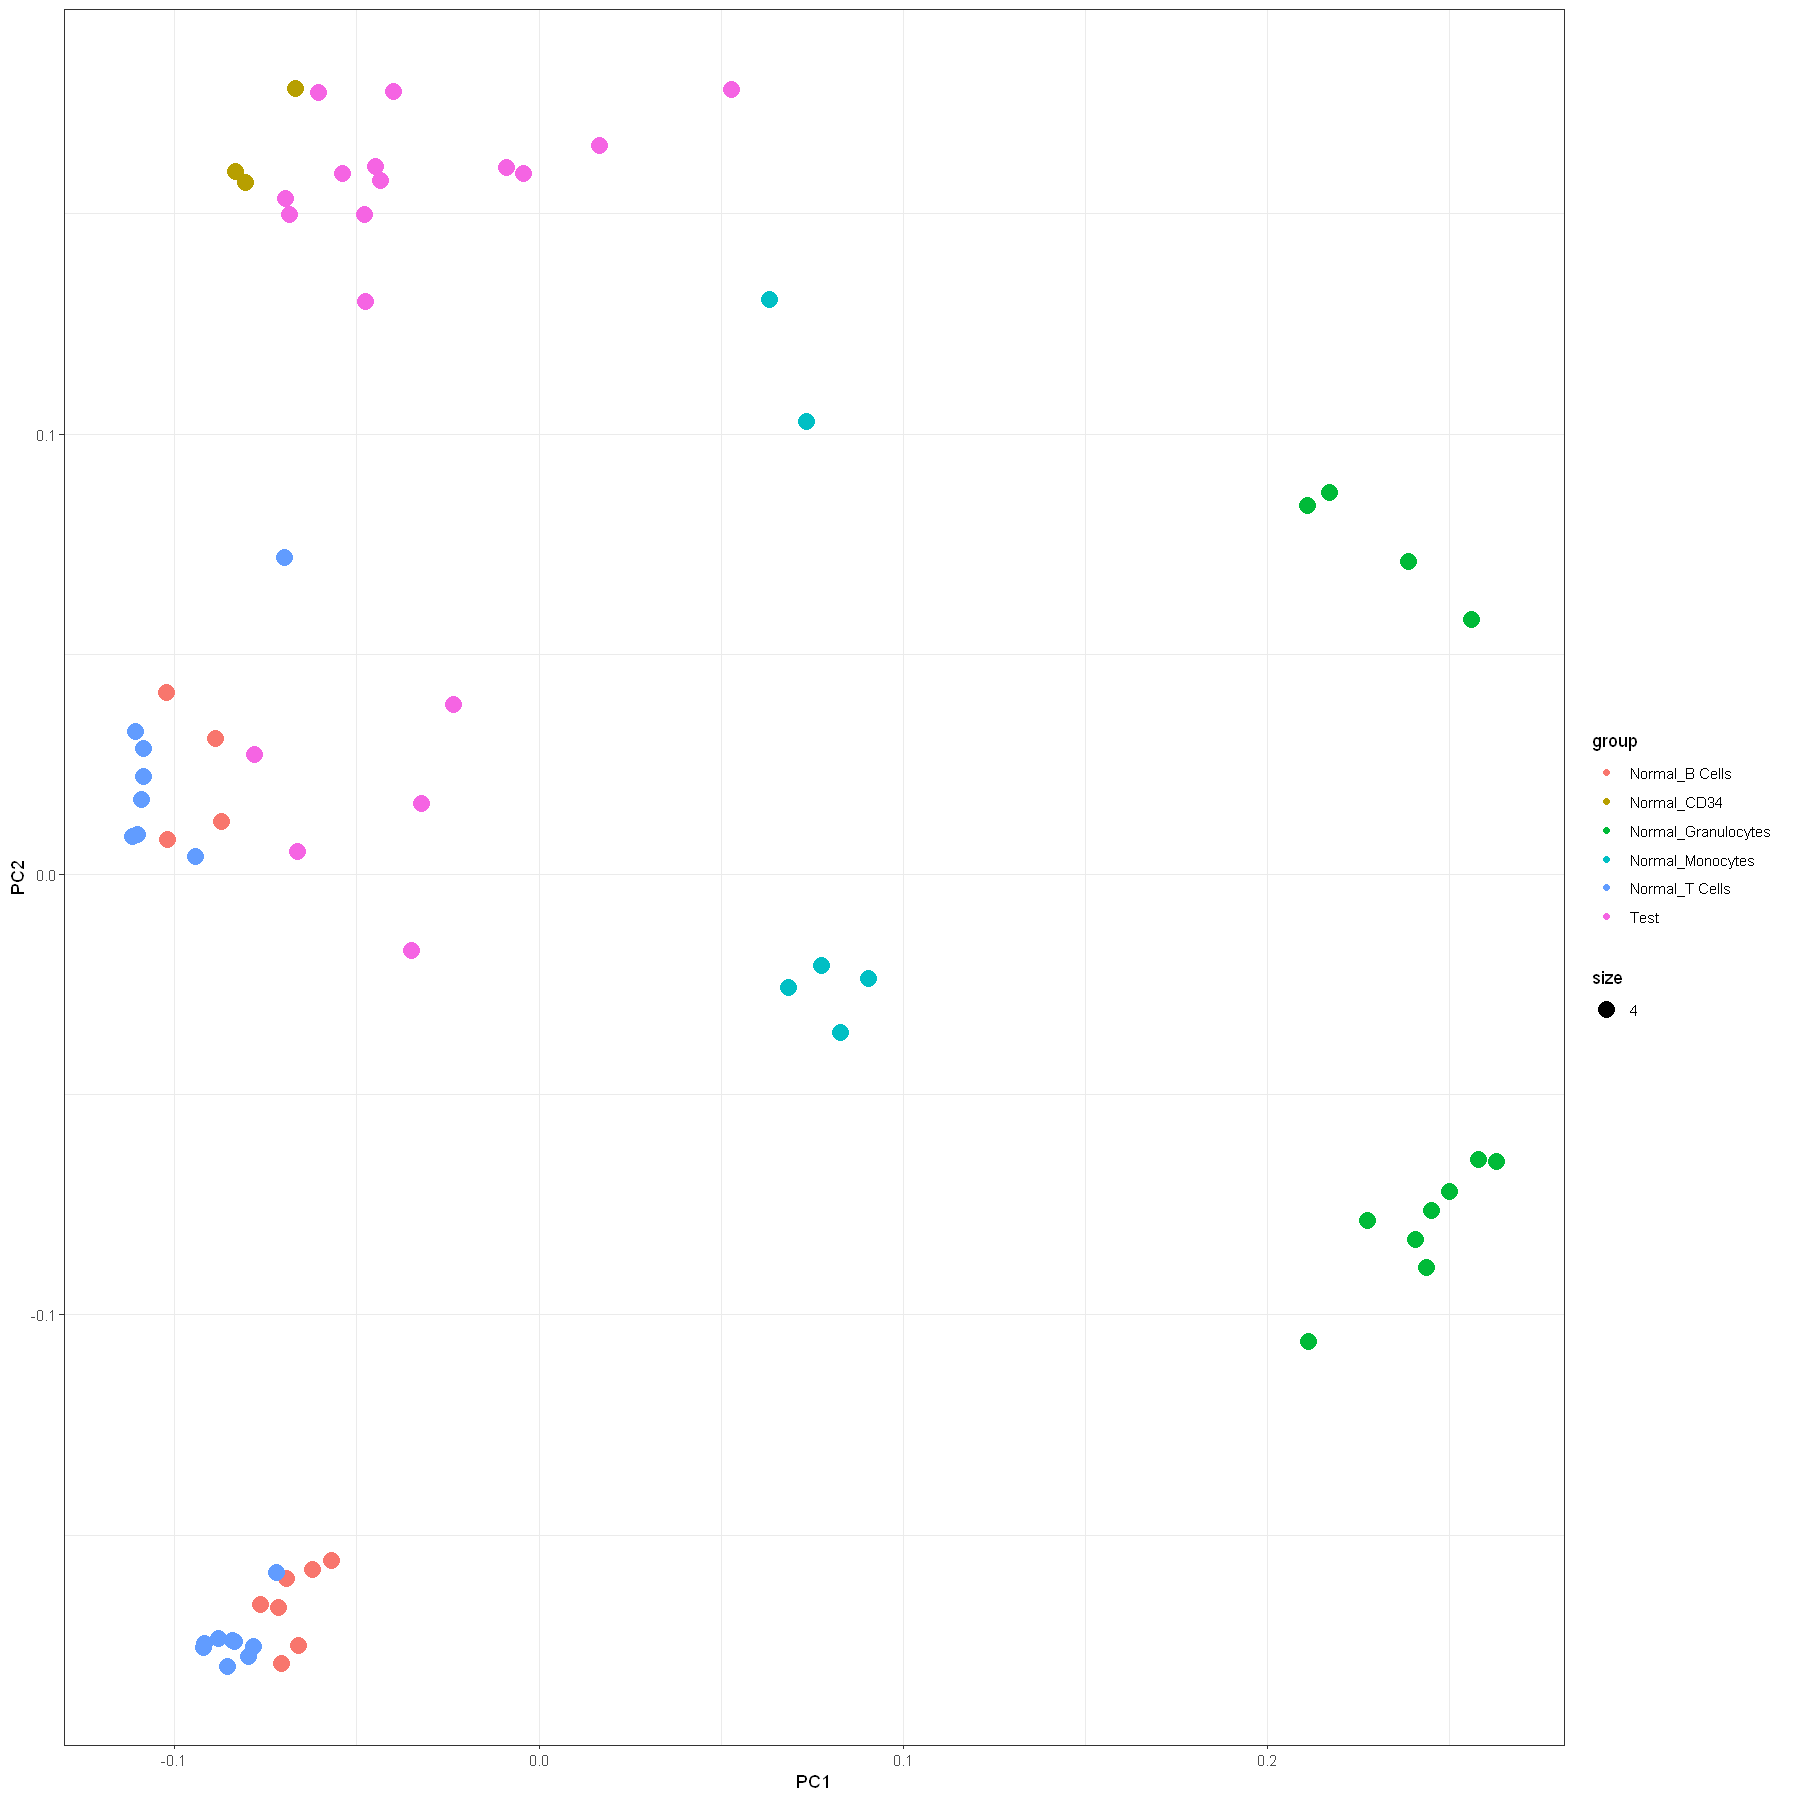

In [42]:
pcar <- data.frame(pca$rotation[,1:3] , group = gr)
options(repr.plot.width = 15 ,repr.plot.height = 15)
ggplot(pcar , aes(PC1 , PC2 , color = group , size = 4)) + geom_point()+ theme_bw()


It seems PCA successfully differntiatied cell types and AML cells can easily be identified.

## Correlation Heatmap

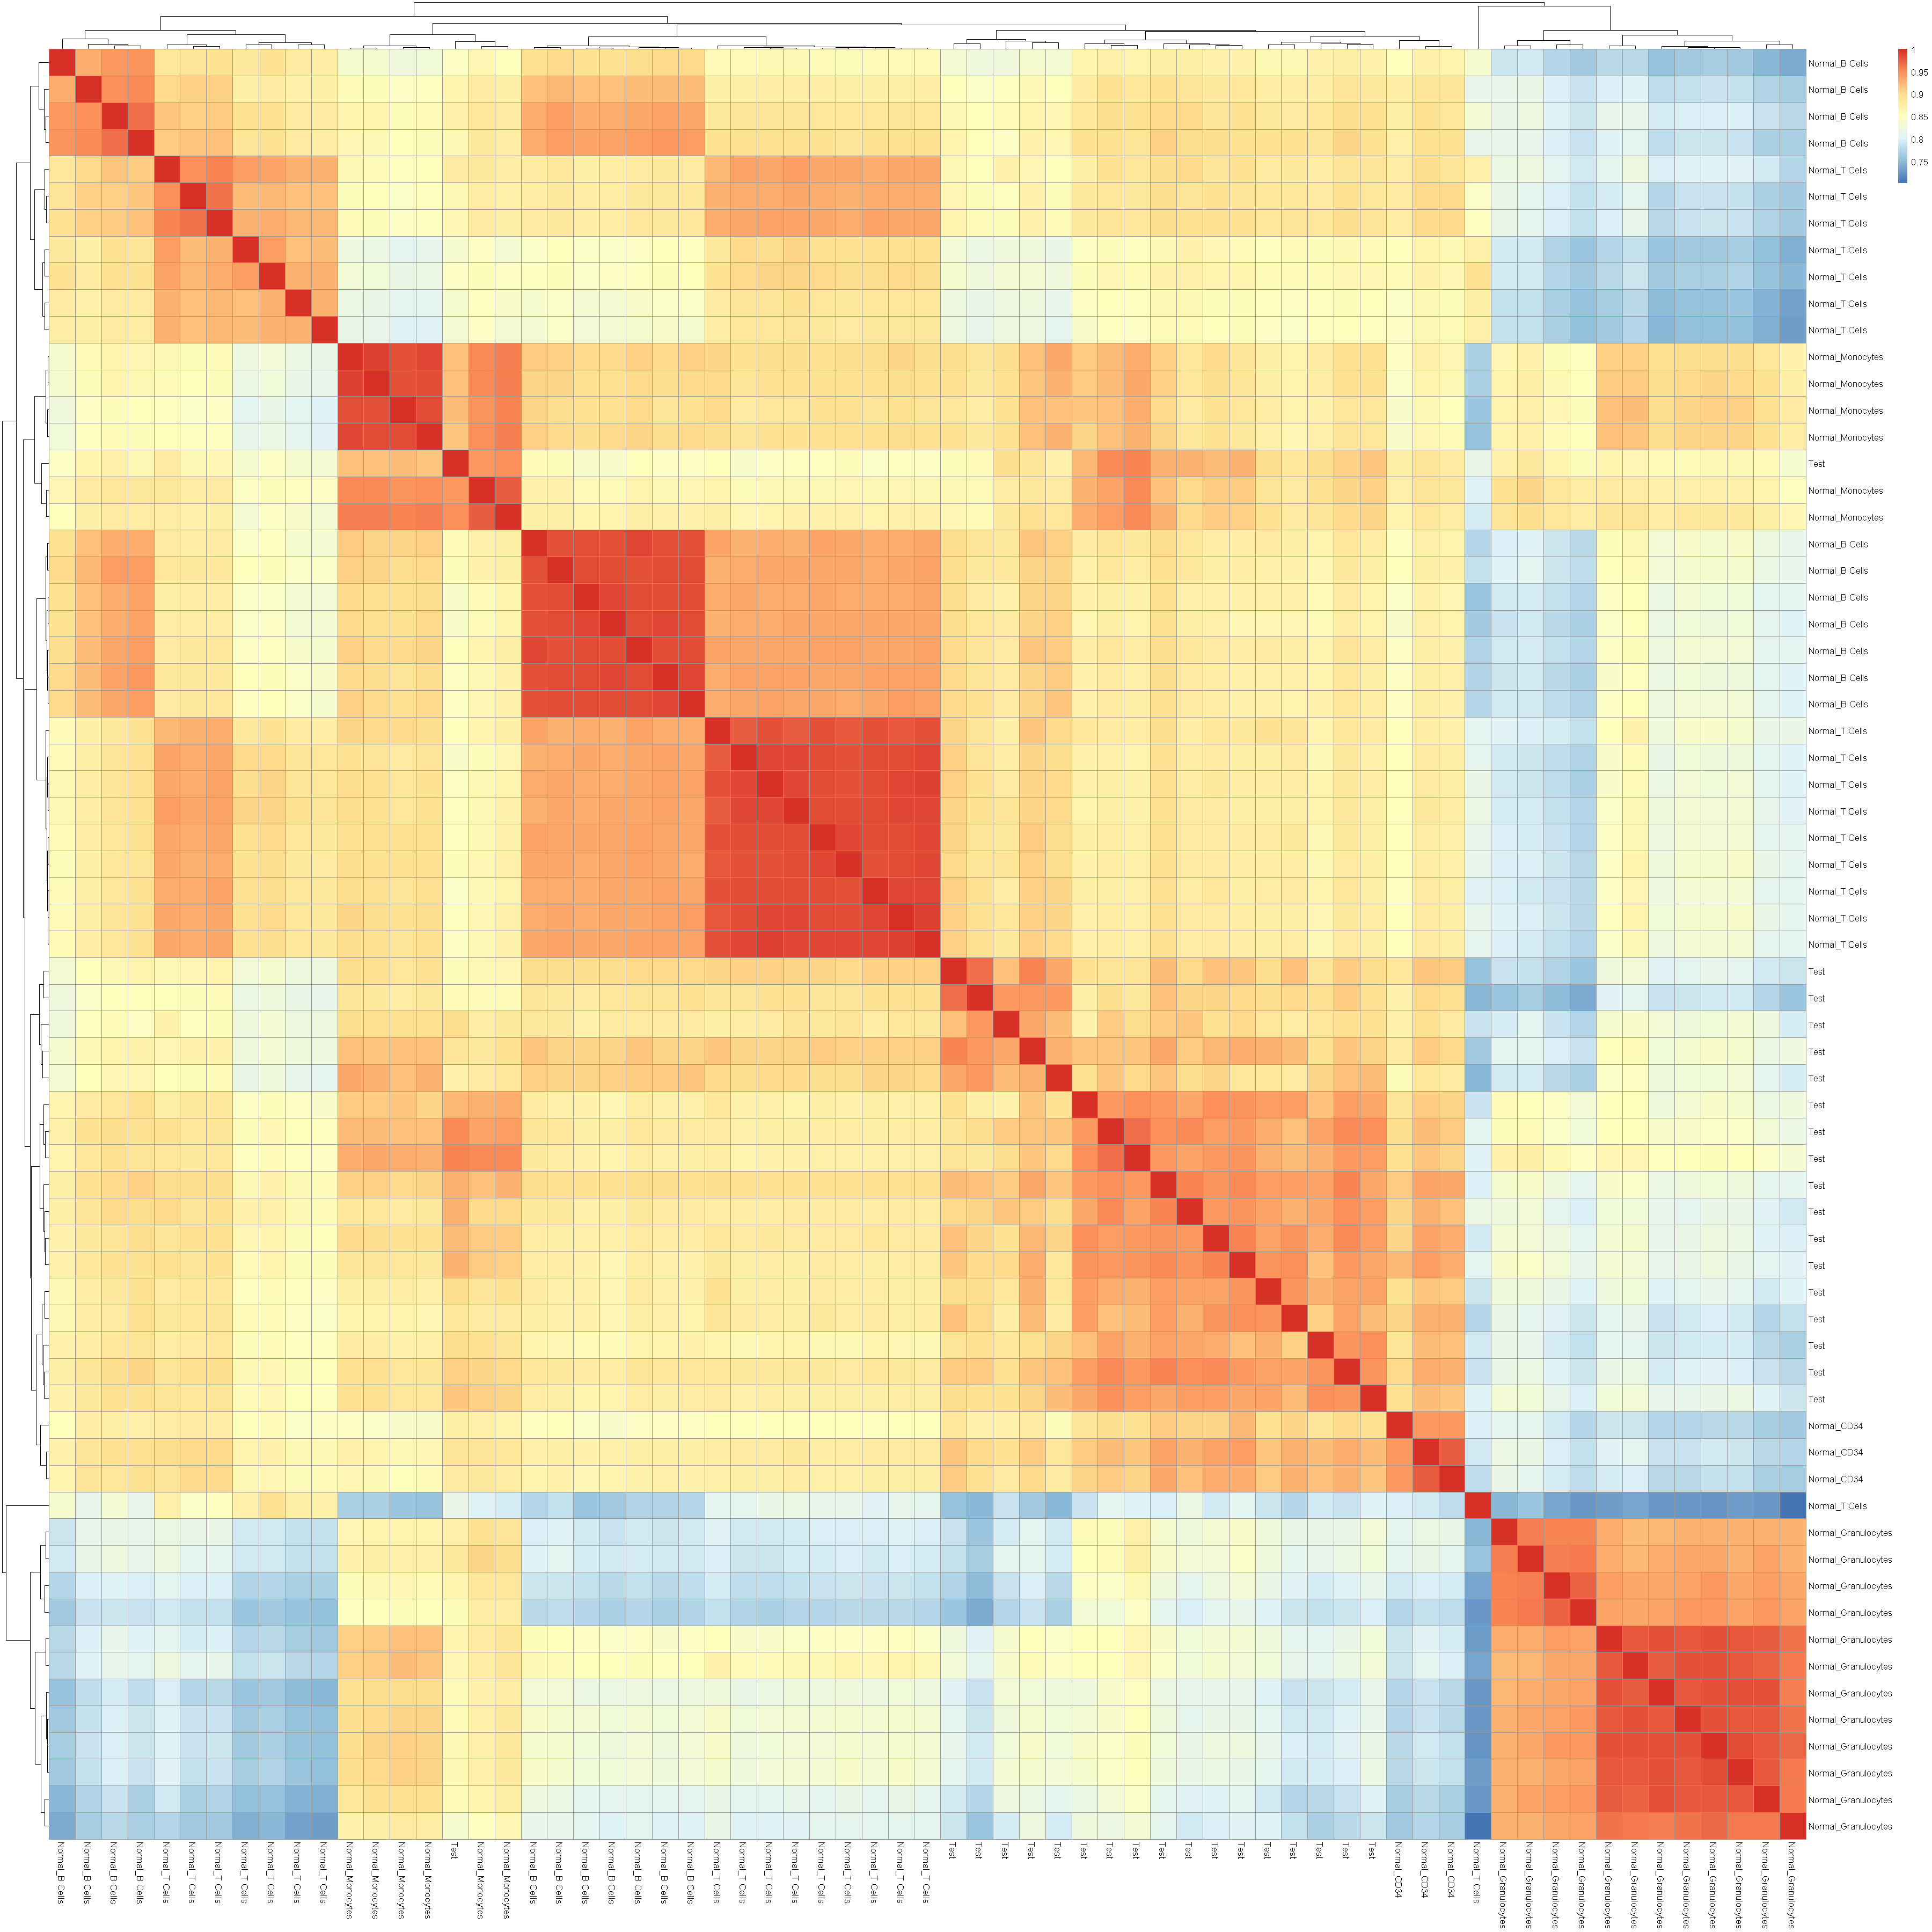

In [43]:
options(repr.plot.width = 30 ,repr.plot.height = 30)
pheatmap(cor(expr) , labels_row =  gr , labels_col =  gr)

## Differentiation Analysis

PCA plot shows us that some "AML Patient" Cells are near CD34 Cells. The correlation between them is also visible in correlation heatmap. We choose them for study. So we use a different label for those "Test" subjects. We label them as "AML_Near_CD34". As we can see, PC2 of those subjects are above 0.13. 

In [21]:
gr2 <- gr
gr2[which(pcar$PC2 > 0.11 & pcar$group == "Test")] <-
  "AML_Near_CD34"
gr2 <- factor(gr2)
gset$description <- gr2

Now, we make a one-hot encoding matrix.

In [22]:
onehot <- model.matrix(~ description + 0, gset)
colnames(onehot) <- levels(gr2)

colnames(onehot) <-
c(sapply(colnames(onehot) , function(x)
    str_replace(x, " ", "_")))
           
           onehot

,AML_Near_CD34,Normal_B_Cells,Normal_CD34,Normal_Granulocytes,Normal_Monocytes,Normal_T_Cells,Test
GSM1180750,1,0,0,0,0,0,0
GSM1180751,1,0,0,0,0,0,0
GSM1180752,1,0,0,0,0,0,0
GSM1180753,1,0,0,0,0,0,0
GSM1180754,1,0,0,0,0,0,0
GSM1180755,1,0,0,0,0,0,0
GSM1180756,1,0,0,0,0,0,0
GSM1180757,1,0,0,0,0,0,0
GSM1180758,1,0,0,0,0,0,0
GSM1180759,1,0,0,0,0,0,0


Now, we make the main table. First we fit a linear model using limma, then we use that linear model to fit a bayesian model. This bayseian model assumes that about 1 precent of genes are signifcant (Prior Knowledge).

In [23]:
fit <- lmFit(gset , onehot)

contrast <-
  makeContrasts(AML_Near_CD34 - Normal_CD34 , levels = onehot)

fit2 <- contrasts.fit(fit , contrast)
fit2 <- eBayes(fit2 , 0.01)
tT <- topTable(fit2,
               adjust = "fdr",
               sort.by = "B" , number = Inf)



Now we select important columns.

In [24]:
tT2 <- subset(tT , select = c("Gene.symbol" , "Gene.title", "adj.P.Val"  , "logFC"))

Genes with high expression in AML have (log fold change > 1) and genes with low expression in AML have (log fold change < -1).

In [26]:
aml.up <- subset(tT2, logFC > 1 & adj.P.Val < 0.05)
aml.up.genes <-unique( as.character(
  strsplit2( (aml.up$Gene.symbol),"///")))
aml.down <- subset(tT2, logFC < -1& adj.P.Val < 0.05)
aml.down.genes <- unique(as.character(
  strsplit2( (aml.down$Gene.symbol),"///")))

In [27]:
print("High Expression Genes:")
aml.up.genes

print("Low Expression Genes:")
aml.down.genes

[1] "High Expression Genes:"


[1] "FYB"            "TLR2"           "PDE3B"          "PRKCD"         
  [5] "TREM1"          "ZNF106"         "CYBB"           "NCF2"          
  [9] "MAN2B1"         ""               "PLD1"           "ATP11A"        
 [13] "SMAP2"          "PP13439"        "CD36"           "IL13RA1"       
 [17] "PTPRJ"          "QSOX1"          "TNFRSF1B"       "FAM107B"       
 [21] "ITGB2"          "FLNA"           "IL10RA"         "ECRP"          
 [25] "IGKC"           "CPEB4"          "CTSH"           "DGKD"          
 [29] "MNDA"           "GRN"            "C3AR1"          "TYROBP"        
 [33] "SRGAP2D"        "FAM129A"        "SLC2A9"         "TLR4"          
 [37] "VCAN"           "TMTC2"          "HMGN2"          "SH3KBP1"       
 [41] "PRR11"          "SIRPA"          "PRKCA"          "HBEGF"         
 [45] "ACPP"           "F13A1"          "RNPEP"          "RAB8A"         
 [49] "IL1RAP"         "FNDC3B"         "WBP2"           "LCP1"          
 [53] "IL17RA"         "FAM46A"         "CSF1R"          "CPD"           
 [57] "FOSL2"          "C10orf12"       "EFR3A"          "MAP2K7"        
 [61] "LY86"           "PDK1"           "TRIB1"          "CLPB"          
 [65] "STAC3"          "ATP6V1B2"       "ITGAM"          "IGHM"          
 [69] "SP140"          "CD68"           "EIF5AL1"        "HBA2"          
 [73] "IFI30"          "PRDM1"          "PTPN18"         "PLCB2"         
 [77] "LYST"           "OSCAR"          "MFN2"           "ARHGAP19-SLIT1"
 [81] "CSF2RA"         "FCER1G"         "POTEF"          "HOMER3"        
 [85] "SNX30"          "SRGAP2C"        "ARSB"           "NT5DC3"        
 [89] "PLEK"           "USF1"           "HAVCR2"         "CDKN2C"        
 [93] "ITGB7"          "TOM1"           "SCFV"           "TCEB3"         
 [97] "ZNF516"         "WARS"           "CD33"           "TIMP1"         
[101] "AOAH"           "TMEM104"        "NEDD9"          "MS4A6A"        
[105] "DOT1L"          "TPD52L2"        "ZNF687"         "SGMS2"         
[109] "CECR1"          "MEF2D"          "MPEG1"          "ATL3"          
[113] "CFP"            "SLC36A1"        "IPCEF1"         "TBC1D8"        
[117] "LILRA2"         "PLAUR"          "DPP9"           "CD96"          
[121] "RNASE6"         "ARF1"           "ACTB"           "LONRF3"        
[125] "UNC93B1"        "HCAR2"          "BSG"            "CTSB"          
[129] "INPPL1"         "MRC1"           "ST6GALNAC4"     "SIRPB2"        
[133] "MYO1F"          "PXK"            "CD4"            "STAB1"         
[137] "CFD"            "DENND1A"        "SPAG5"          "TADA2B"        
[141] "CD86"           "TBC1D1"         "PIWIL4"         "ADAP2"         
[145] "GAS7"           "PAG1"           "CD180"          "HAL"           
[149] "NABP1"          "SGSH"           "LRRC25"         "CD1D"          
[153] "CLEC12A"        "PROK2"          "BROX"           "ADRB2"         
[157] "HMGXB4"         "SRGAP2"         "GPR132"         "HCAR3"         
[161] "STK17B"         "ITGAX"          "FAM53B"         "EPB41"         
[165] "CCDC59"         "IQGAP3"         "DIAPH2"         "CD300C"        
[169] "CBL"            "PTP4A2"         "NETO2"          "PITPNM1"       
[173] "SLFN5"          "FEZ2"           "NFIL3"          "TRAK2"         
[177] "HBB"            "GABPB2"         "SCPEP1"         "MITF"          
[181] "CPM"            "FANCD2"         "RASSF4"         "LRP1"          
[185] "FAM72A"         "HK2"            "UNC119"         "NDRG1"         
[189] "SLC4A1"         "BANF1"          "GLUL"           "PLIN2"         
[193] "IGF2R"          "SYNE2"          "AAK1"           "DCUN1D1"       
[197] "KAT2B"          "CCL5"           "MYOF"           "RASGRP3"       
[201] "ITK"            "TAF5L"          "SNX11"          "SAMHD1"        
[205] "FCGR2C"         "PPP1CA"         "KPNA6"          "IL7R"          
[209] "PLPP6"          "JAZF1"          "CHD7"           "KYNU"          
[213] "PARP8"          "SIGLEC9"        "ANAPC15"        "FGR"           
[217] 

[1] "Low Expression Genes:"


[1] "MPDZ"                   "PRKG2"                  "CHRM3"                 
  [4] "HLF"                    "FREM1"                  "NKAIN2"                
  [7] "NAP1L3"                 "PLCB4"                  "PBX1"                  
 [10] "SGIP1"                  ""                       "CRHBP"                 
 [13] "SGCZ"                   "EMCN"                   "FAT4"                  
 [16] "ST6GAL2"                "LIMCH1"                 "RPS6KA6"               
 [19] "DTX3"                   "HFM1"                   "PRKG1"                 
 [22] "HTR1F"                  "RNF150"                 "ELN"                   
 [25] "ADGRG6"                 "BEX2"                   "CDH7"                  
 [28] "PLOD2"                  "CEP126"                 "SPOCK3"                
 [31] "CNN3"                   "NUDT11"                 "LRCH2"                 
 [34] "VWDE"                   "PDZD2"                  "ELAC2"                 
 [37] "SLC22A17"               "CCDC175"                "SYTL4"                 
 [40] "ABI3BP"                 "FAM19A2"                "CTSF"                  
 [43] "FHL1"                   "SDR42E1"                "STAC"                  
 [46] "GPR21"                  "MYCT1"                  "PRO2012"               
 [49] "NAP1L2"                 "RAB38"                  "ARMC4"                 
 [52] "PLS3"                   "TCTEX1D1"               "STARD9"                
 [55] "IL12RB2"                "KLF3-AS1"               "TMEM136"               
 [58] "JAM2"                   "CXorf57"                "PDZRN4"                
 [61] "PGM5P2"                 "ARMCX1"                 "SLC25A27"              
 [64] "MCF2L2"                 "TRO"                    "PLA2R1"                
 [67] "RNF17"                  "ATP9A"                  "CP"                    
 [70] "BEND7"                  "BEX5"                   "L3MBTL4"               
 [73] "CHRNA5"                 "TSPAN6"                 "TMEM163"               
 [76] "MTURN"                  "LTBP3"                  "ARHGAP22"              
 [79] "ARG2"                   "TVP23A"                 "ARHGEF17"              
 [82] "PRSS3P2"                "TAPT1-AS1"              "CYYR1"                 
 [85] "TSPYL5"                 "SCD"                    "ENO2"                  
 [88] "FBN1"                   "SEPT5-GP1BB"            "GPC5"                  
 [91] "CA13"                   "TMEM220"                "LOC400464"             
 [94] "MYO5C"                  "SMO"                    "LDOC1"                 
 [97] "REC8"                   "METTL24"                "CACNB2"                
[100] "TSPAN2"                 "TRIM74"                 "TCEAL9"                
[103] "SNHG16"                 "MIPOL1"                 "CALN1"                 
[106] "TXNRD3NB"               "SYDE2"                  "FAM169A"               
[109] "LRRN1"                  "PCDH9"                  "MDGA2"                 
[112] "FIGN"                   "PACRG"                  "UCHL1"                 
[115] "NSUN7"                  "FGD5"                   "VWA2"                  
[118] "ZBED8"                  "ZNRF1"                  "SERPINE2"              
[121] "PCYT1B"                 "ZNF300"                 "PGM5"                  
[124] "SPINK2"                 "DKFZP434L187"           "GATS"                  
[127] "DPPA4"                  "MIR24-2"                "CAMLG"                 
[130] "C1orf21"                "THRB"                   "SYS1-DBNDD2"           
[133] "STK33"                  "GCNT2"                  "MME"                   
[136] "SEMA3C"                 "PREX2"                  "SETBP1"                
[139] "SLC16A2"                "ID1"                    "SLC8A3"                
[142] "LOC100134868"           "AASS"                   "SLC29A2"               
[145] "TMEM98"                 "MPPED2"                 "RAPGEF3"               
[148] "C10orf10"               "F